In [1]:
!pip install opencv-python ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 65.8 MB/s eta 0:00:00


In [2]:
!pip install iterative-stratification

Make sure the following folders are correct for you.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd 'drive/Othercomputers/My Computer (1)/EmotionTeller-github'

/content/drive/Othercomputers/My Computer (1)/EmotionTeller-github


We import the metadata and remove the rows of missing files.

In [6]:
import pandas as pd
import ast
import os

data_root       = 'Data' # Folder where all data sources are stored
data_folders    = 'ImageData' # List of folders containing images in .jpg format
data_meta       = ['emotic-relabelled.csv',
                'hgel-relabelled.csv'] # List of metadata corresponding to previous list of folders in .csv format. In our case we relabelled some of the data, so this is different from original metadata.
meta_root       = 'Metadata'

In [15]:
df = pd.read_csv(os.path.join(meta_root,'train_meta.csv'))
df['objects'] = df['objects'].apply(lambda x: ast.literal_eval(x))

# Check if the file exists for each row
df['file_exists'] = df.apply(lambda x: os.path.exists(os.path.join(data_root,data_folders,x.file_name)),axis = 1)

# Drop rows where the file does not exist
df = df[df.file_exists]
df.drop(columns=['file_exists'], inplace=True)

df.head()

,file_name,objects,original_width,original_height,emotions
0,2w4w14gc7v0zzlo2hr.jpg,"{'bbox': [[53.203433030794265, 17.615104049146...",300,361,['Sad']
1,30nuw6i66lmickmbly.jpg,"{'bbox': [[26.798646725660358, 15.553243651943...",500,489,['Sad']
2,6ypnlgwpdwm4cxhzyq.jpg,"{'bbox': [[39.807704879496356, 5.2996237628844...",393,233,['Disgust']
3,7yfw4gdcdak0kdvqu2.jpg,"{'bbox': [[47.60784313725491, 6.43835340508561...",184,274,['Sad']
4,9uq1l58tusi8vij6ju.jpg,"{'bbox': [[38.745098039215634, 17.137253719272...",200,300,['Sad']


In [7]:
import cv2
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Basic train test split, with no regards for balancing or anything.

In [17]:
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np

mlb = MultiLabelBinarizer()

X = df[['file_name']]
y = mlb.fit_transform(df['emotions'])

mss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
idx = np.arange(len(df))

(train_idx, test_idx), = mss.split(idx, y)

train_df = df.iloc[train_idx].reset_index(drop=True)
val_df  = df.iloc[test_idx].reset_index(drop=True)

The emotions to be detected by the model.

In [18]:
emo_dic = {'Neutral':0,'Happy':1,'Surprise':2,'Sad':3,'Angry':4,'Fear':5,'Disgust':6}

The following two cells, create new folders with labels and pictures for our training and validation sets according the structure required by `YOLO`.

In [19]:
yolo_dir = 'YOLO_training'
os.makedirs(yolo_dir, exist_ok=True)

source = 'Human-Group-Emotions-Labelled/'

def xywh2xcycwh(x,y,w,h):
  return [x + w/2, y + h/2, w/2, h/2]

def label(item):
  objs = item['objects']
  text_label = ''
  for ind, emotion in enumerate(objs['categories']):
    x,y,w,h = np.array(objs['bbox'][ind])/100 # Unpack the list into four variables
    xc,yc,wc,hc = xywh2xcycwh(x,y,w,h) # Pass the four variables to the function
    text_label += f'{emo_dic[emotion]} {xc} {yc} {wc} {hc}\n'
  return text_label

In [ ]:
import shutil

# Create directories for train and validation images and labels
os.makedirs(os.path.join(yolo_dir,'images','train'), exist_ok=True)
os.makedirs(os.path.join(yolo_dir,'labels','train'), exist_ok=True)
os.makedirs(os.path.join(yolo_dir,'images','val'), exist_ok=True)
os.makedirs(os.path.join(yolo_dir,'labels','val'), exist_ok=True)

# Generate labels and copy images for the training set
for index, row in train_df.iterrows():
    image_name = row['file_name']
    label_content = label(row)
    with open(os.path.join(yolo_dir,'labels','train',image_name.replace('.jpg', '.txt')), 'w') as f:
        f.write(label_content)
    shutil.copy(os.path.join(data_root,data_folders,image_name), os.path.join(yolo_dir,'images','train',image_name))

# Generate labels and copy images for the validation set
for index, row in test_df.iterrows():
    image_name = row['file_name']
    label_content = label(row) # FIX THIS
    with open(os.path.join(yolo_dir,'labels','val',image_name.replace('.jpg', '.txt')), 'w') as f:
        f.write(label_content)
    shutil.copy(os.path.join(data_root,data_folders,image_name), os.path.join(yolo_dir,'images/val/',image_name))

print("Generated label files and copied images for train and validation sets.")

Generated label files and copied images for train and validation sets.


Make sure `data.yaml` is in the `ds_folder`, this contains the structure for the train/val pictures and labels.

In [ ]:
model = YOLO('yolo11n.pt')

results = model.train(data = os.path.join(yolo_dir,'data.yaml'), project= os.path.join(yolo_dir,"runs"), imgsz=1024, epochs = 300,device=0, rect= True)

Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=YOLO_training/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=300, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True,

We use our model to predict on train and validation sets. Make sure you select the correct weights for the latest run.

In [ ]:
fine_tuned = YOLO('YOLO_training/train/weights/best.pt')

val_df['path_to_img'] = val_df.apply(lambda x: os.path.join(yolo_dir,'images','val',x.file_name),axis=1)

train_df['path_to_img'] = train_df.apply(lambda x: os.path.join(yolo_dir,'images','train',x.file_name),axis=1)

train_preds = fine_tuned.predict(list(train_df['path_to_img']))
val_preds = fine_tuned.predict(list(val_df['path_to_img']))


0: 1024x1024 (no detections), 1.4ms
1: 1024x1024 (no detections), 1.4ms
2: 1024x1024 (no detections), 1.4ms
3: 1024x1024 (no detections), 1.4ms
4: 1024x1024 (no detections), 1.4ms
5: 1024x1024 1 Sad, 1.4ms
6: 1024x1024 1 Angry, 1.4ms
7: 1024x1024 1 Neutral, 1 Angry, 1.4ms
8: 1024x1024 2 Neutrals, 1.4ms
9: 1024x1024 (no detections), 1.4ms
10: 1024x1024 1 Angry, 1.4ms
11: 1024x1024 1 Angry, 1.4ms
12: 1024x1024 1 Disgust, 1.4ms
13: 1024x1024 1 Happy, 1.4ms
14: 1024x1024 1 Angry, 1.4ms
15: 1024x1024 2 Angrys, 1.4ms
16: 1024x1024 (no detections), 1.4ms
17: 1024x1024 1 Angry, 1.4ms
18: 1024x1024 1 Angry, 1.4ms
19: 1024x1024 1 Sad, 1.4ms
20: 1024x1024 1 Sad, 1.4ms
21: 1024x1024 (no detections), 1.4ms
22: 1024x1024 1 Angry, 1.4ms
23: 1024x1024 (no detections), 1.4ms
24: 1024x1024 7 Fears, 1.4ms
25: 1024x1024 (no detections), 1.4ms
26: 1024x1024 (no detections), 1.4ms
27: 1024x1024 1 Disgust, 1.4ms
28: 1024x1024 2 Fears, 1.4ms
29: 1024x1024 (no detections), 1.4ms
30: 1024x1024 (no detections),

To see how this compares to original labelling, set `pic_id` to any index in the training dataset and run the cell below it.

In [ ]:
pic_id=55

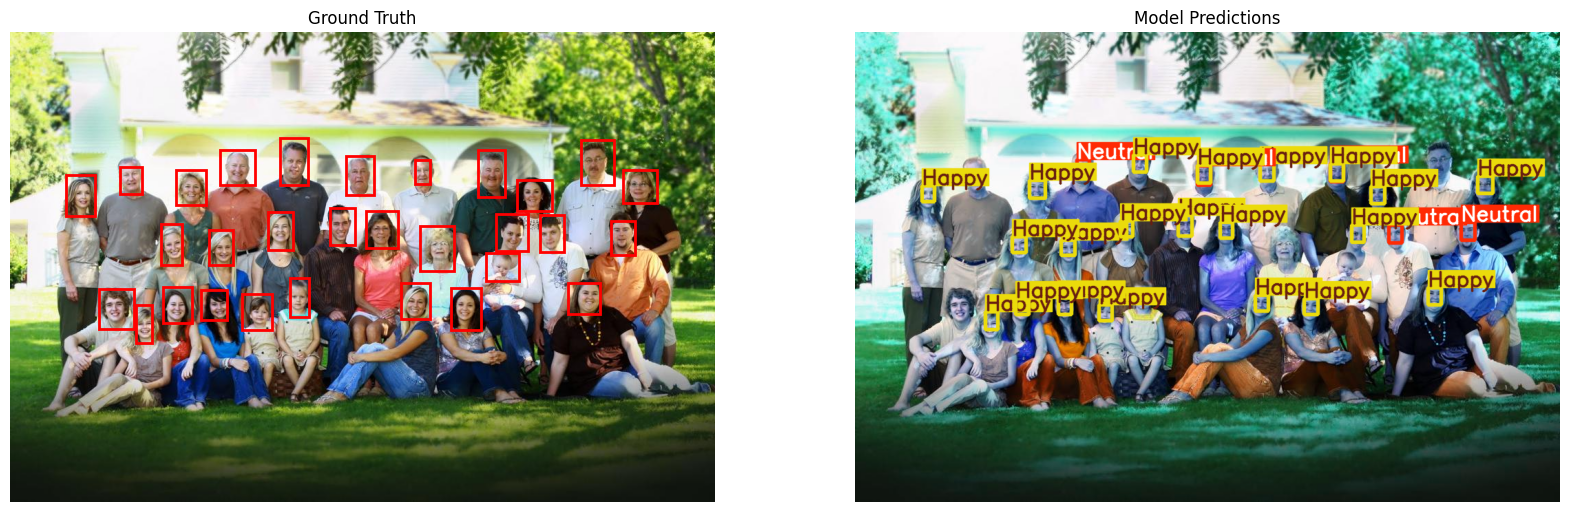

In [ ]:
# @title
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

test = train_df.iloc[pic_id]

width = test['original_width']
height = test['original_height']

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Display the original image with ground truth bounding boxes on the left subplot
axes[0].imshow(Image.open(os.path.join(yolo_dir,'images','train',test['file_name'])))
axes[0].set_title('Ground Truth')
axes[0].axis("off")

for bbox in test['objects']['bbox']:
  bbox = np.array(bbox)/100
  x, y, w, h = bbox*[width,height,width,height]

  # Create a Rectangle patch
  rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')

  # Add the patch to the Axes
  axes[0].add_patch(rect)

#Display the image with model predictions on the right subplot
axes[1].imshow(train_preds[pic_id].plot(conf = False, line_width = int(width*0.003))) # YOLO's plot method returns an image
axes[1].set_title('Model Predictions')
axes[1].axis("off")

plt.show()

### Training with KFolds

Below we will create stratified KFolds and split our images to train following this [guide](https://docs.ultralytics.com/guides/kfold-cross-validation/#k-fold-dataset-split) and this [package](https://github.com/trent-b/iterative-stratification).

In [9]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
from pathlib import Path

In [44]:
dataset_path = Path("Data") / "ImageData"  # replace with 'path/to/dataset' for your custom data

In [45]:
df = pd.read_csv(os.path.join(meta_root,'train_meta.csv'))
df['objects'] = df['objects'].apply(lambda x: ast.literal_eval(x))

# Check if the file exists for each row
df['file_exists'] = df.apply(lambda x: os.path.exists(os.path.join(data_root,data_folders,x.file_name)),axis = 1)

# Drop rows where the file does not exist
df = df[df.file_exists]
df.drop(columns=['file_exists'], inplace=True)

df.head()

,file_name,objects,original_width,original_height,emotions
0,2w4w14gc7v0zzlo2hr.jpg,"{'bbox': [[53.203433030794265, 17.615104049146...",300,361,['Sad']
1,30nuw6i66lmickmbly.jpg,"{'bbox': [[26.798646725660358, 15.553243651943...",500,489,['Sad']
2,6ypnlgwpdwm4cxhzyq.jpg,"{'bbox': [[39.807704879496356, 5.2996237628844...",393,233,['Disgust']
3,7yfw4gdcdak0kdvqu2.jpg,"{'bbox': [[47.60784313725491, 6.43835340508561...",184,274,['Sad']
4,9uq1l58tusi8vij6ju.jpg,"{'bbox': [[38.745098039215634, 17.137253719272...",200,300,['Sad']


In [28]:
index = list(df['file_name'])

mlb = MultiLabelBinarizer()

X = df[['file_name']]
y = mlb.fit_transform(df['emotions'])

ksplit = 5

msk = MultilabelStratifiedKFold(n_splits=ksplit, shuffle=True, random_state=42)
idx = np.arange(len(df))

folds = [f"split_{n}" for n in range(1, ksplit + 1)]
folds_df = pd.DataFrame(index=index, columns=folds)

kfolds = list(msk.split(idx, y))

for i, (train_idx, val_idx) in enumerate(kfolds, start=1):
    col = f"split_{i}"
    col_pos = folds_df.columns.get_loc(col)
    folds_df.iloc[train_idx,col_pos] = "train"
    folds_df.iloc[val_idx,col_pos] = "val"



In [29]:
import datetime
import yaml

yaml_file = os.path.join("YOLO_training","data.yaml")  # your data YAML with data directories and names dictionary
with open(yaml_file, encoding="utf8") as y:
    classes = yaml.safe_load(y)["names"]

# List with image file paths
images = list(df["file_name"].apply(lambda x: dataset_path/x))

# Create the necessary directories and dataset YAML files
save_path = Path("YOLO_training") / f"{datetime.date.today().isoformat()}_{ksplit}-Fold_Cross-val"
save_path.mkdir(parents=True, exist_ok=True)
ds_yamls = []

for split in folds_df.columns:
    # Create directories
    split_dir = save_path / split
    split_dir.mkdir(parents=True, exist_ok=True)
    (split_dir / "train" / "images").mkdir(parents=True, exist_ok=True)
    (split_dir / "train" / "labels").mkdir(parents=True, exist_ok=True)
    (split_dir / "val" / "images").mkdir(parents=True, exist_ok=True)
    (split_dir / "val" / "labels").mkdir(parents=True, exist_ok=True)

    # Create dataset YAML files
    dataset_yaml = split_dir / f"{split}_dataset.yaml"
    ds_yamls.append(dataset_yaml)

    with open(dataset_yaml, "w") as ds_y:
        yaml.safe_dump(
            {
                "path": split_dir.as_posix(),
                "train": "train",
                "val": "val",
                "names": classes,
            },
            ds_y,
        )

In [47]:
for index, row in df.iterrows():
    print(row['objects'])
    break

{'bbox': [[53.203433030794265, 17.615104049146684, 33.96738025028607, 46.64979212224452]], 'categories': ['Sad']}


In [49]:
import shutil
from tqdm import tqdm

for image in tqdm(images, total=len(images), desc="Copying files"):
    for split, k_split in folds_df.loc[image.name].items():
        # Destination directory
        img_to_path = save_path / split / k_split / "images"
        lbl_to_path = save_path / split / k_split / "labels"

        # Copy image and label files to new directory (SamefileError if file already exists)
        shutil.copy(image, img_to_path / image.name)
        row = df.loc[df["file_name"] == image.name].iloc[0]
        label_content = label(row)
        with open(lbl_to_path/image.name.replace('.jpg', '.txt'), 'w') as f:
            f.write(label_content)

Copying files: 100%|██████████| 178/178 [01:40<00:00,  1.77it/s]


In [50]:
results = {}

batch = 32
project = os.path.join(yolo_dir,"kfold_runs")
epochs = 300
model = YOLO('yolo11n.pt')
weights_path = 'yolo11n.pt'

for k, dataset_yaml in enumerate(ds_yamls):
    model = YOLO(weights_path, task="detect")
    results[k] = model.train(
        data=dataset_yaml, epochs=epochs, batch=batch, project=project, name=f"fold_{k + 1}", imgsz=1024, device=0, rect= True
    )  # include any additional train arguments

Streaming output truncated to the last 5000 lines.
                   all         35        212      0.317      0.192       0.14     0.0388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     65/300      13.1G      1.594      1.577       1.13         23        768: 100% ━━━━━━━━━━━━ 5/5 5.6it/s 0.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 6.1it/s 0.2s
                   all         35        212      0.396       0.12      0.095     0.0297

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     66/300      13.1G      1.662      1.569      1.148         23        768: 100% ━━━━━━━━━━━━ 5/5 5.6it/s 0.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 5.8it/s 0.2s
                   all         35        212       0.39      0.146     0.0796     0.0246

      Epoch    GPU_mem   box_loss   cls_loss 

In [23]:
ksplit = 5

results = []

for k in range(ksplit):
  results.append(pd.read_csv(Path('YOLO_training')/'kfold_runs'/f'fold_{k+1}'/'results.csv').iloc[-1])


In [42]:
results[0]

,170
epoch,171.000000
time,297.137000
train/box_loss,0.984340
train/cls_loss,0.678840
train/dfl_loss,0.890020
metrics/precision(B),0.229970
metrics/recall(B),0.132170
metrics/mAP50(B),0.082520
metrics/mAP50-95(B),0.024170
val/box_loss,2.644630


In [41]:
np.array([result['metrics/mAP50(B)'] for result in results]).mean()

np.float64(0.10464799999999999)

In [40]:
np.array([result['metrics/recall(B)'] for result in results]).mean()

np.float64(0.146876)

In [39]:
np.array([result['metrics/precision(B)'] for result in results]).mean()

np.float64(0.229638)

In [ ]:
fine_tuned = YOLO(Path('YOLO_training')/'kfold_runs'/f'fold_{k+1}'/'weights'/'best.pt')

val_df['path_to_img'] = val_df.apply(lambda x: os.path.join(yolo_dir,'images','val',x.file_name),axis=1)

train_df['path_to_img'] = train_df.apply(lambda x: os.path.join(yolo_dir,'images','train',x.file_name),axis=1)

train_preds = fine_tuned.predict(list(train_df['path_to_img']))
val_preds = fine_tuned.predict(list(val_df['path_to_img']))

Visualizing results from fold 4

0: 1024x1024 (no detections), 5.9ms
1: 1024x1024 (no detections), 5.9ms
2: 1024x1024 1 Neutral, 1 Happy, 1 Surprise, 1 Sad, 5.9ms
3: 1024x1024 1 Neutral, 5.9ms
4: 1024x1024 (no detections), 5.9ms
5: 1024x1024 2 Neutrals, 5.9ms
6: 1024x1024 (no detections), 5.9ms
7: 1024x1024 1 Disgust, 5.9ms
8: 1024x1024 (no detections), 5.9ms
9: 1024x1024 (no detections), 5.9ms
10: 1024x1024 1 Neutral, 5.9ms
11: 1024x1024 3 Neutrals, 5.9ms
12: 1024x1024 14 Neutrals, 7 Happys, 5.9ms
13: 1024x1024 4 Neutrals, 5.9ms
14: 1024x1024 (no detections), 5.9ms
15: 1024x1024 6 Neutrals, 3 Happys, 5.9ms
16: 1024x1024 (no detections), 5.9ms
17: 1024x1024 1 Neutral, 3 Happys, 5.9ms
18: 1024x1024 2 Happys, 5.9ms
19: 1024x1024 6 Happys, 5.9ms
20: 1024x1024 4 Neutrals, 5.9ms
21: 1024x1024 1 Neutral, 5.9ms
22: 1024x1024 1 Neutral, 5.9ms
23: 1024x1024 1 Neutral, 5.9ms
24: 1024x1024 (no detections), 5.9ms
25: 1024x1024 6 Neutrals, 2 Happys, 5.9ms
26: 1024x1024 1 Neutral, 4 Happys, 5.9ms
27

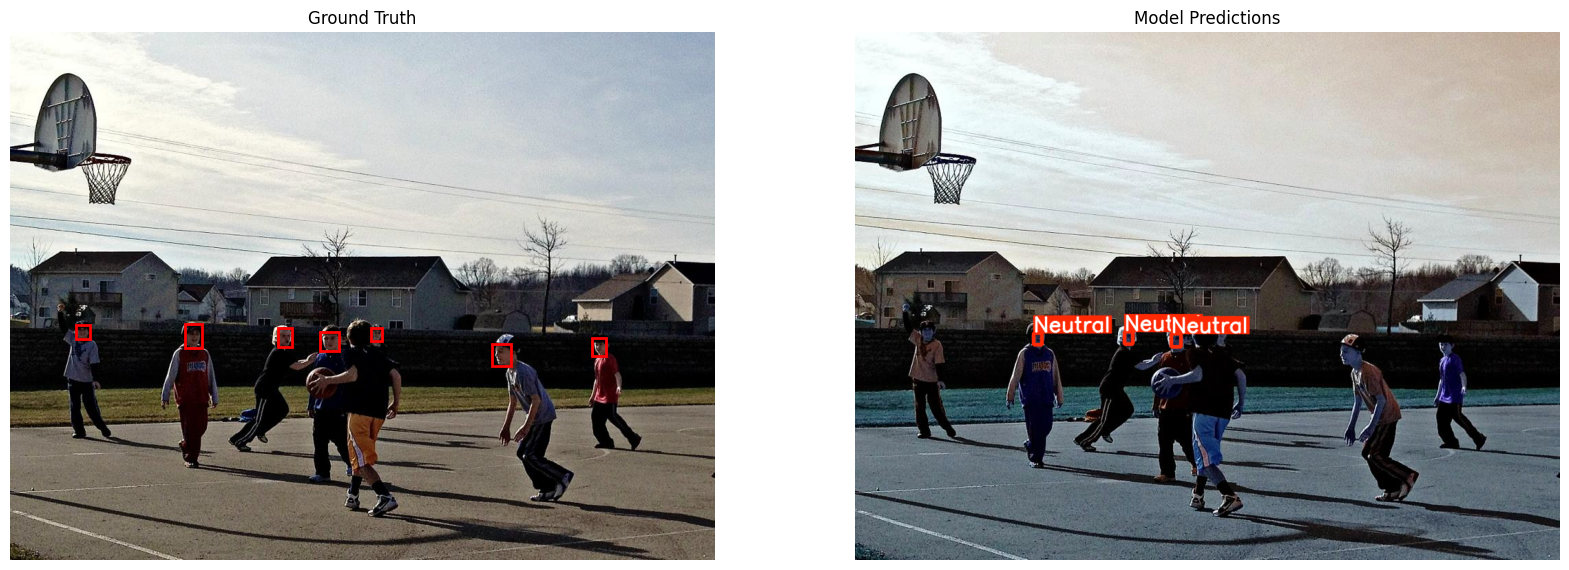

In [53]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import random
import pandas as pd
import os
import ast
from ultralytics import YOLO
from pathlib import Path
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import datetime
import yaml


# Load and process metadata to define df
meta_root = 'Metadata'
data_root = 'Data'
data_folders = 'ImageData'

df = pd.read_csv(os.path.join(meta_root,'train_meta.csv'))
df['objects'] = df['objects'].apply(lambda x: ast.literal_eval(x))

# Check if the file exists for each row
df['file_exists'] = df.apply(lambda x: os.path.exists(os.path.join(data_root,data_folders,x.file_name)),axis = 1)

# Drop rows where the file does not exist
df = df[df.file_exists]
df.drop(columns=['file_exists'], inplace=True)

# Set the index of df to file_name to align with folds_df
df.set_index('file_name', inplace=True)

# Define folds_df and save_path
index = list(df.index) # Use the index of df

mlb = MultiLabelBinarizer()

y = mlb.fit_transform(df['emotions'])

ksplit = 5

msk = MultilabelStratifiedKFold(n_splits=ksplit, shuffle=True, random_state=42)
idx = np.arange(len(df))

folds = [f"split_{n}" for n in range(1, ksplit + 1)]
folds_df = pd.DataFrame(index=index, columns=folds)

kfolds = list(msk.split(idx, y))

for i, (train_idx, val_idx) in enumerate(kfolds, start=1):
    col = f"split_{i}"
    col_pos = folds_df.columns.get_loc(col)
    folds_df.iloc[train_idx,col_pos] = "train"
    folds_df.iloc[val_idx,col_pos] = "val"

save_path = Path("YOLO_training") / f"{datetime.date.today().isoformat()}_{ksplit}-Fold_Cross-val"


# Select a random fold to visualize results from (you can change this)
fold_to_visualize = random.randint(0, ksplit - 1)
print(f"Visualizing results from fold {fold_to_visualize + 1}")

# Load the best model from the selected fold
fine_tuned_kfold = YOLO(Path('YOLO_training')/'kfold_runs'/f'fold_{fold_to_visualize+1}'/'weights'/'best.pt')

# Get the validation dataframe for the selected fold
val_split_col = f"split_{fold_to_visualize + 1}"
val_df_kfold = df[folds_df[val_split_col] == 'val'].reset_index() # Keep the index as a column

# Add the path to the images for the selected validation set
val_df_kfold['path_to_img'] = val_df_kfold['file_name'].apply(lambda x: save_path/val_split_col/'val'/'images'/x)

# Get predictions for the validation set of the selected fold
val_preds_kfold = fine_tuned_kfold.predict(list(val_df_kfold['path_to_img']))



In [70]:
# Select a random image from the validation set to visualize (you can change the index)
# pic_id_kfold = random.randint(0, len(val_df_kfold) - 1)
# test_kfold = val_df_kfold.iloc[pic_id_kfold]

# Create a dropdown menu to select the image
from ipywidgets import Dropdown, Output, VBox
from IPython.display import display

image_dropdown = Dropdown(
    options=val_df_kfold['file_name'].tolist(),
    description='Select Image:',
    disabled=False,
)

output = Output()

def on_image_dropdown_change(change):
    with output:
        output.clear_output()
        selected_image_name = change['new']
        test_kfold = val_df_kfold[val_df_kfold['file_name'] == selected_image_name].iloc[0]

        width_kfold = test_kfold['original_width']
        height_kfold = test_kfold['original_height']

        # Create a figure with two subplots
        fig, axes = plt.subplots(1, 2, figsize=(20, 10))

        # Display the original image with ground truth bounding boxes on the left subplot
        axes[0].imshow(Image.open(test_kfold['path_to_img']))
        axes[0].set_title('Ground Truth')
        axes[0].axis("off")

        for bbox in test_kfold['objects']['bbox']:
          bbox = np.array(bbox)/100
          x, y, w, h = bbox*[width_kfold,height_kfold,width_kfold,height_kfold]

          # Create a Rectangle patch
          rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')

          # Add the patch to the Axes
          axes[0].add_patch(rect)

        #Display the image with model predictions on the right subplot
        # Find the index of the selected image in the original val_df_kfold to get the corresponding prediction result
        selected_image_index = val_df_kfold[val_df_kfold['file_name'] == selected_image_name].index[0]

        axes[1].imshow(val_preds_kfold[selected_image_index].plot(conf = False, line_width = int(width_kfold*0.003))) # YOLO's plot method returns an image
        axes[1].set_title('Model Predictions')
        axes[1].axis("off")

        plt.show()

image_dropdown.observe(on_image_dropdown_change, names='value')

display(VBox([image_dropdown, output]))

TODO:
- Hyperparameter tuning
- Data augmentation